# Designing a Solution for the BrisT1D Blood Glucose Prediction Competition
Welcome! In this guide, we'll develop a comprehensive solution for predicting blood glucose levels one hour into the future using the provided dataset. We'll work step-by-step, explaining each part thoroughly to ensure clarity and understanding.

**Table of Contents**

1. Introduction
2. Setup and Library Imports
3. Data Loading
4. Exploratory Data Analysis (EDA)
5. Data Preprocessing
6. Feature Engineering
7. Model Selection
8. Baseline Model
9. Advanced Models
10. Model Evaluation
11. Hyperparameter Tuning
12. Visualizing Model Performance
13. Feature Importance Analysis Using SHAP
14. Cross-Validation
15. Ensemble Models (XGBoost and CatBoost)
16. Preparing Submission
17. Conclusion

## Introduction
The goal is to predict blood glucose levels an hour into the future based on historical data collected from participants with type 1 diabetes. The dataset includes various physiological and behavioral features over six hours, aggregated in five-minute intervals.

## Setup and Library Imports
First, let's set up our environment by importing necessary libraries.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import xgboost as xgb

# Settings
%matplotlib inline
sns.set(style="darkgrid")

## Data Loading
Load the training and test datasets.

In [2]:
# Assuming the datasets are in the same directory as the notebook
train = pd.read_csv(r'C:\Users\Spici\Downloads\brist1d\train.csv', low_memory=False)
test = pd.read_csv(r'C:\Users\Spici\Downloads\brist1d\test.csv')
sample_submission = pd.read_csv(r'C:\Users\Spici\Downloads\brist1d\sample_submission.csv')

Check the first few rows of the training data.

In [3]:
train.head()

,id,p_num,time,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,...,activity-0:40,activity-0:35,activity-0:30,activity-0:25,activity-0:20,activity-0:15,activity-0:10,activity-0:05,activity-0:00,bg+1:00
0,p01_0,p01,06:10:00,NaN,NaN,9.6,NaN,NaN,9.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.4
1,p01_1,p01,06:25:00,NaN,NaN,9.7,NaN,NaN,9.2,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.8
2,p01_2,p01,06:40:00,NaN,NaN,9.2,NaN,NaN,8.7,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.5
3,p01_3,p01,06:55:00,NaN,NaN,8.7,NaN,NaN,8.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.8
4,p01_4,p01,07:10:00,NaN,NaN,8.4,NaN,NaN,8.1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.7


## Exploratory Data Analysis (EDA)

Understanding the data is crucial. We'll explore the datasets to identify patterns, missing values, and potential issues.

### Basic Information

In [4]:
print("Training data shape:", train.shape)
print("Test data shape:", test.shape)

Training data shape: (177024, 508)
Test data shape: (3644, 507)


#### Data Types and Missing Values

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 177024 entries, 0 to 177023
Columns: 508 entries, id to bg+1:00
dtypes: float64(433), object(75)
memory usage: 686.1+ MB


Check for missing values.

In [6]:
train.isnull().sum()

id                    0
p_num                 0
time                  0
bg-5:55           27254
bg-5:50           18491
                  ...  
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
bg+1:00               0
Length: 508, dtype: int64

Visualize missing data.

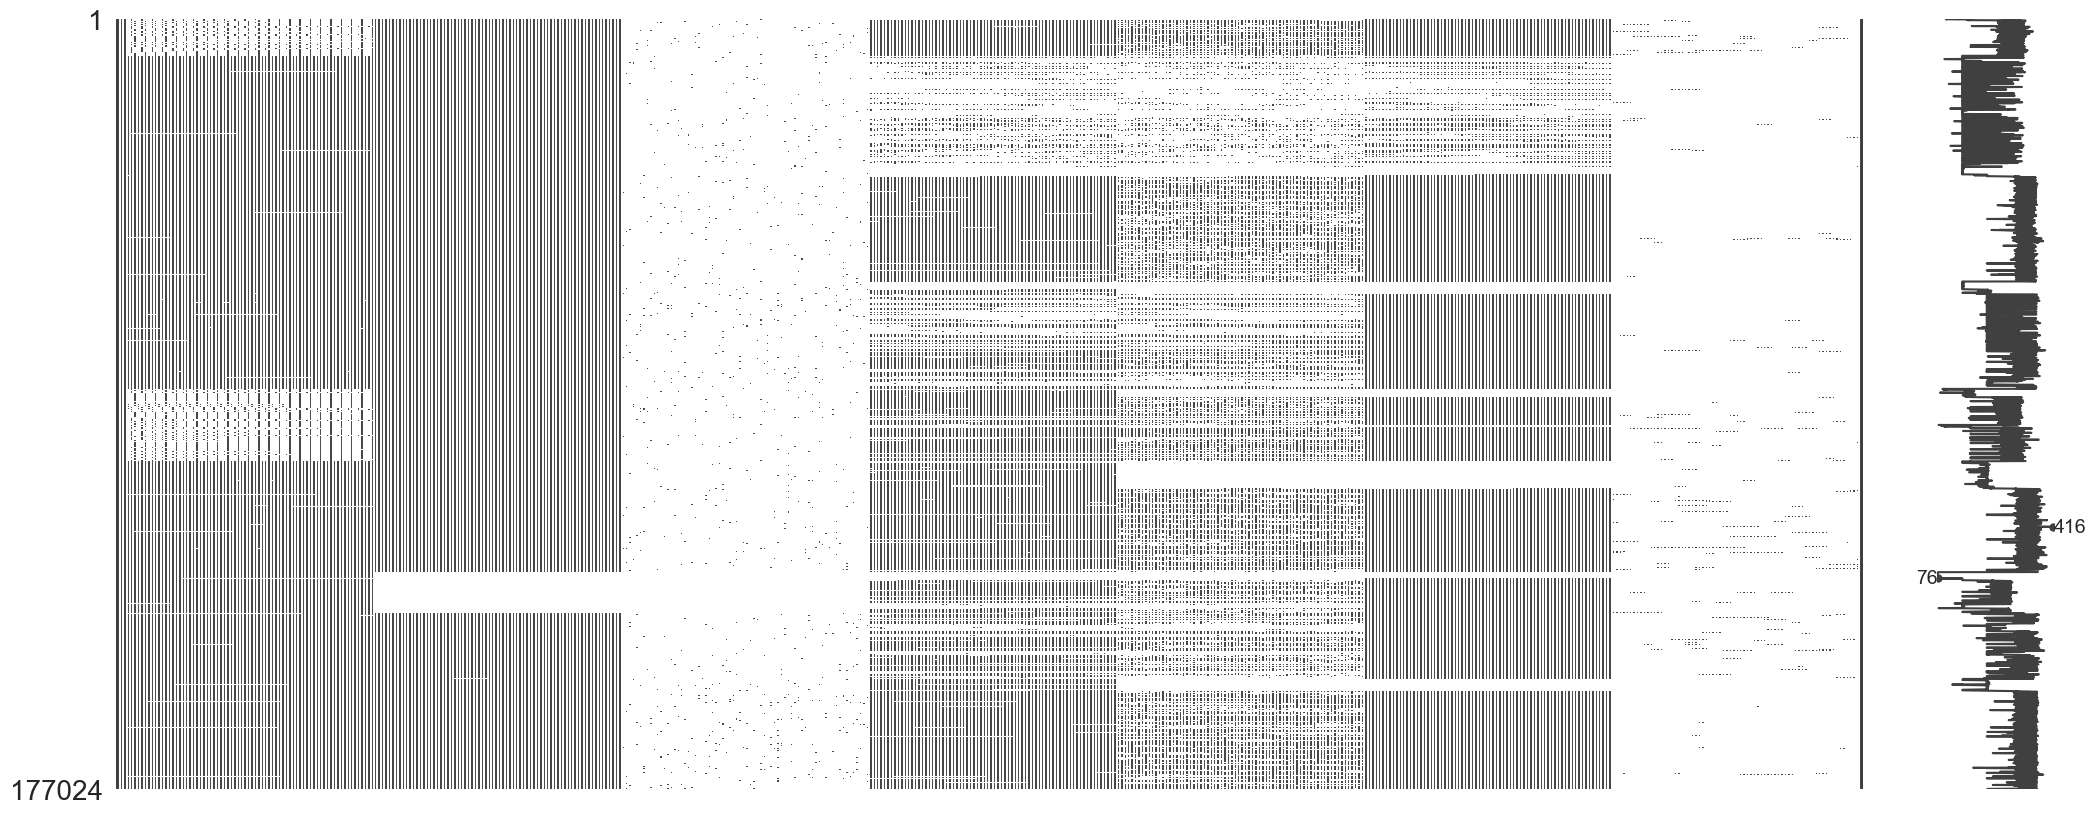

In [7]:
import missingno as msno
msno.matrix(train)
plt.show()

#### Statistical Summary

In [8]:
train.describe()

,bg-5:55,bg-5:50,bg-5:45,bg-5:40,bg-5:35,bg-5:30,bg-5:25,bg-5:20,bg-5:15,bg-5:10,...,cals-0:40,cals-0:35,cals-0:30,cals-0:25,cals-0:20,cals-0:15,cals-0:10,cals-0:05,cals-0:00,bg+1:00
count,149770.000000,158533.000000,163364.000000,149766.000000,158254.000000,163770.000000,149763.000000,157973.000000,164174.000000,149771.000000,...,141694.000000,141706.000000,141713.000000,141722.000000,141732.000000,141741.000000,141751.000000,141761.000000,141767.000000,177024.000000
mean,8.211018,8.230449,8.253291,8.210988,8.229649,8.254083,8.211049,8.228888,8.254602,8.211000,...,9.364063,9.364096,9.362525,9.366591,9.368108,9.366998,9.370010,9.372536,9.368960,8.277045
std,2.852188,2.913438,2.945594,2.852090,2.911313,2.947651,2.852212,2.909304,2.949689,2.852315,...,8.012264,8.012681,8.017508,8.018465,8.018349,8.023788,8.021999,8.023280,8.023327,2.996398
min,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,2.200000,...,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,2.200000
25%,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,6.100000,...,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,5.600000,6.100000
50%,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,7.600000,7.700000,7.600000,...,6.180000,6.180000,6.170000,6.180000,6.180000,6.180000,6.180000,6.180000,6.180000,7.700000
75%,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,9.800000,...,9.060000,9.060000,9.050000,9.060000,9.060000,9.060000,9.060000,9.070000,9.060000,9.900000
max,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,25.100000,27.800000,22.200000,...,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,116.100000,27.800000


#### Target Variable Distribution
Plot the distribution of the target variable `bg+1:00`.

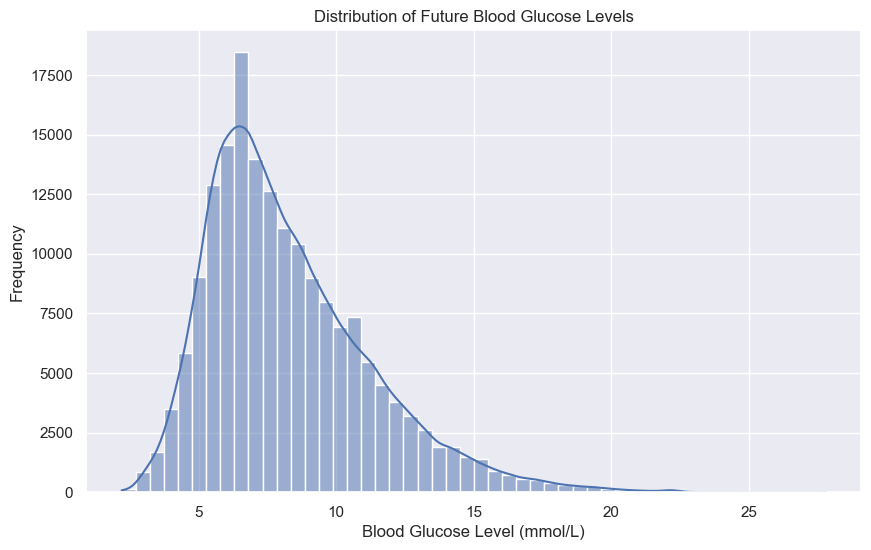

In [9]:
plt.figure(figsize=(10,6))
sns.histplot(train['bg+1:00'], bins=50, kde=True)
plt.title('Distribution of Future Blood Glucose Levels')
plt.xlabel('Blood Glucose Level (mmol/L)')
plt.ylabel('Frequency')
plt.show()

## Data Preprocessing
Address missing values, data types, and any anomalies.

#### Handling Missing Values
Identify columns with missing values.

In [10]:
missing_values = train.isnull().sum()
missing_values = missing_values[missing_values > 0]
print(missing_values)

bg-5:55           27254
bg-5:50           18491
bg-5:45           13660
bg-5:40           27258
bg-5:35           18770
                  ...  
activity-0:20    174270
activity-0:15    174293
activity-0:10    174287
activity-0:05    174271
activity-0:00    174287
Length: 504, dtype: int64


#### Strategy for Missing Values
* Numerical Features: Use imputation (mean, median).
* Categorical Features: Use imputation (custom constant).
#### Imputing Missing Values

In [11]:
# Separate features and target
X = train.drop(['id', 'p_num', 'time', 'bg+1:00'], axis=1)
y = train['bg+1:00']

# Identify numerical and categorical columns
numerical_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns

# Impute numerical features with median
num_imputer = SimpleImputer(strategy='median')
X[numerical_cols] = num_imputer.fit_transform(X[numerical_cols])

# Impute categorical features with a placeholder
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
X[categorical_cols] = cat_imputer.fit_transform(X[categorical_cols])

Apply the same transformations to the test set.

In [12]:
test_data = test.drop(['id', 'p_num', 'time'], axis=1)

# Impute numerical features
test_data[numerical_cols] = num_imputer.transform(test_data[numerical_cols])

# Impute categorical features
test_data[categorical_cols] = cat_imputer.transform(test_data[categorical_cols])

#### Encoding Categorical Variables
Use one-hot encoding for the `activity` features.

In [13]:
X = pd.get_dummies(X, columns=categorical_cols, drop_first=True)
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)

# Align the train and test data
X, test_data = X.align(test_data, join='left', axis=1, fill_value=0)

#### Feature Scaling
Standardize the numerical features using robust scaling method to address skewness of the variables and outliers.

In [14]:
# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform training data
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])

# Transform test data
test_data[numerical_cols] = scaler.transform(test_data[numerical_cols])

## Feature Engineering
Create additional features that may help the model.

#### Time-Based Features
Extract hour and minute from the `time` column.

In [15]:
# Define the time format
time_format = '%H:%M:%S'

# Convert 'time' to datetime using the specified format
train['time'] = pd.to_datetime(train['time'], format=time_format)
test['time'] = pd.to_datetime(test['time'], format=time_format)

# Extract hour and minute
train['hour'] = train['time'].dt.hour
train['minute'] = train['time'].dt.minute

test['hour'] = test['time'].dt.hour
test['minute'] = test['time'].dt.minute

# Add 'hour' and 'minute' to feature set using pd.concat to avoid fragmentation
X = pd.concat([X, train[['hour', 'minute']]], axis=1)
test_data = pd.concat([test_data, test[['hour', 'minute']]], axis=1)

#### Lag Features
Create lag features for important variables.

In [16]:
# Define lag features and create lagged data for X
lag_features = ['bg-0:00', 'insulin-0:00', 'carbs-0:00', 'hr-0:00']
lagged_train_features = []
lagged_test_features = []

for lag in [1, 2, 3]:
    for feature in lag_features:
        # Create lagged features for both train and test
        lagged_train_features.append(X[feature].shift(lag).rename(f'{feature}_lag{lag}'))
        lagged_test_features.append(test_data[feature].shift(lag).rename(f'{feature}_lag{lag}'))

# Concatenate all lagged features at once
X = pd.concat([X] + lagged_train_features, axis=1)
test_data = pd.concat([test_data] + lagged_test_features, axis=1)

# Handle NaN values after shifting
X = X.bfill()
test_data = test_data.bfill()

## Model Selection
Based on the data and problem, consider several models:

* Linear Regression
* Gradient Boosting Machines (XGBoost)
* CatBoost
* Ensemble of the Best Performers
* Neural Networks (if computationally feasible)

We'll start with a baseline model and then move to more complex models.

#### Baseline Model
##### Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression

# Split the data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on validation set
y_pred = lr_model.predict(X_valid)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Baseline Linear Regression RMSE: {rmse:.4f}')

Baseline Linear Regression RMSE: 2.1332


#### Advanced Models
##### XGBoost Regressor

In [18]:
# Initialize the model
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on validation set
y_pred = xgb_model.predict(X_valid)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'XGBoost RMSE: {rmse:.4f}')

XGBoost RMSE: 1.9076


#### CatBoost Regressor
First, we'll need to install CatBoost if it's not already installed.

In [19]:
# Install CatBoost if necessary
%pip install catboost

Note: you may need to restart the kernel to use updated packages.


Import the CatBoost library.

In [20]:
from catboost import CatBoostRegressor

Training the CatBoost Model

In [21]:
# Initialize the model
cat_model = CatBoostRegressor(
    iterations=1000,
    learning_rate=0.1,
    depth=6,
    loss_function='RMSE',
    verbose=100,
    random_seed=42
)

# Identify categorical features (if any)
# Since we've already encoded categorical features, we might not have any
# But if we had, CatBoost can handle them natively
categorical_features_indices = np.where(X.dtypes == 'object')[0]

# Train the model
cat_model.fit(
    X_train, y_train,
    eval_set=(X_valid, y_valid),
    cat_features=categorical_features_indices,
    use_best_model=True,
    early_stopping_rounds=50
)

0:	learn: 2.8575263	test: 2.8730139	best: 2.8730139 (0)	total: 459ms	remaining: 7m 38s
100:	learn: 1.9584019	test: 1.9993247	best: 1.9993247 (100)	total: 25.9s	remaining: 3m 50s
200:	learn: 1.8899138	test: 1.9477085	best: 1.9477085 (200)	total: 49.6s	remaining: 3m 17s
300:	learn: 1.8409472	test: 1.9171034	best: 1.9171034 (300)	total: 1m 13s	remaining: 2m 50s
400:	learn: 1.8010220	test: 1.8930472	best: 1.8930472 (400)	total: 1m 36s	remaining: 2m 24s
500:	learn: 1.7682015	test: 1.8762443	best: 1.8762443 (500)	total: 1m 59s	remaining: 1m 59s
600:	learn: 1.7388223	test: 1.8598656	best: 1.8598656 (600)	total: 2m 22s	remaining: 1m 34s
700:	learn: 1.7113949	test: 1.8461221	best: 1.8461221 (700)	total: 2m 45s	remaining: 1m 10s
800:	learn: 1.6866754	test: 1.8331999	best: 1.8331999 (800)	total: 3m 8s	remaining: 46.9s
900:	learn: 1.6627854	test: 1.8211468	best: 1.8211468 (900)	total: 3m 31s	remaining: 23.3s
999:	learn: 1.6418256	test: 1.8113984	best: 1.8113984 (999)	total: 3m 54s	remaining: 0us



**Explanation:**

* `iterations`: Number of boosting iterations.
* `learning_rate`: Step size shrinkage used to prevent overfitting.
* `depth`: Depth of the tree. Deeper trees can capture more complex patterns but may overfit.
* `loss_function`: We use 'RMSE' since the evaluation metric is RMSE.
* `verbose`: Controls the logging output.
* `random_seed`: For reproducibility.
* `cat_features`: Indices of categorical features. CatBoost can handle categorical variables without one-hot encoding.

**Evaluating the CatBoost Model**

In [22]:
# Predict on validation set
y_pred = cat_model.predict(X_valid)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'CatBoost RMSE: {rmse:.4f}')

CatBoost RMSE: 1.8114


#### Comparing Model Performance

In [23]:
models = {
    'Linear Regression': lr_model,
    'XGBoost': xgb_model,
    'CatBoost': cat_model
}

for name, model in models.items():
    if name == 'CatBoost':
        y_pred = model.predict(X_valid)
    elif name == 'XGBoost':
        y_pred = model.predict(X_valid)
    else:
        y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'{name} RMSE: {rmse:.4f}')

Linear Regression RMSE: 2.1332
XGBoost RMSE: 1.9076
CatBoost RMSE: 1.8114


## Hyperparameter Tuning
Fine-tune the models to improve performance.

#### XGBoost Hyperparameter Tuning

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [6, 8],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb_cv = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)

xgb_cv.fit(X_train, y_train)

print("Best parameters:", xgb_cv.best_params_)

# Evaluate the best model
best_xgb = xgb_cv.best_estimator_
y_pred = best_xgb.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Tuned XGBoost RMSE: {rmse:.4f}')

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 200, 'subsample': 0.8}
Tuned XGBoost RMSE: 1.7712


#### Hyperparameter Tuning for CatBoost
To improve the CatBoost model, let's perform hyperparameter tuning.

In [25]:
from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid
param_grid = {
    'iterations': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7],
    'bagging_temperature': [0, 1, 2],
    'border_count': [32, 50, 100],
}

# Initialize the CatBoost regressor
cat_model = CatBoostRegressor(
    loss_function='RMSE',
    eval_metric='RMSE',
    random_seed=42,
    early_stopping_rounds=50,
    verbose=0
)

# Initialize RandomizedSearchCV
cat_random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
cat_random_search.fit(X_train, y_train, eval_set=(X_valid, y_valid), use_best_model=True)

# Best parameters
print("Best parameters:", cat_random_search.best_params_)

# Evaluate the best model
best_cat = cat_random_search.best_estimator_
y_pred = best_cat.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
print(f'Tuned CatBoost RMSE: {rmse:.4f}')

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1500, 'depth': 8, 'border_count': 100, 'bagging_temperature': 1}
Tuned CatBoost RMSE: 1.6671


#### Final Model Evaluation

Here, we make the final comparision between the baseline model and fine-tuned versions of XGBoost and CatBoost.

In [26]:
models = {
    'Linear Regression': lr_model,
    'XGBoost': best_xgb,
    'CatBoost': best_cat
}

for name, model in models.items():
    y_pred = model.predict(X_valid)
    rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
    print(f'{name} RMSE: {rmse:.4f}')

Linear Regression RMSE: 2.1332
XGBoost RMSE: 1.7712
CatBoost RMSE: 1.6671


## Visualizing Model Performance
#### Plotting Predicted vs. Actual Values
We can plot the predicted vs. actual blood glucose levels to visualize how well each model is performing.

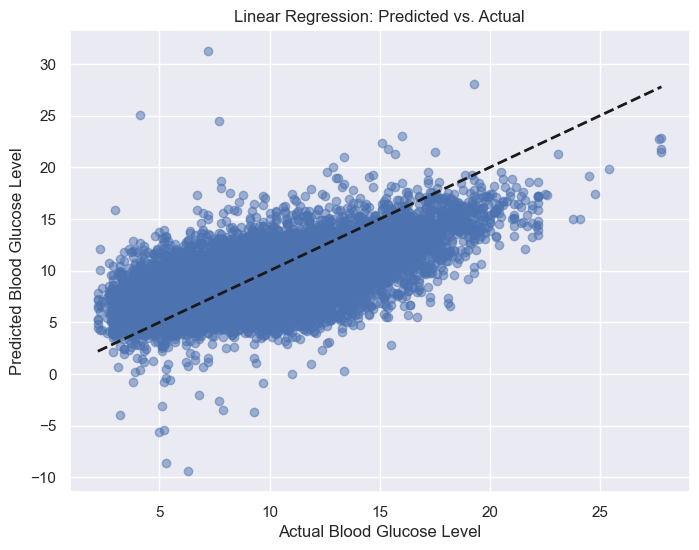

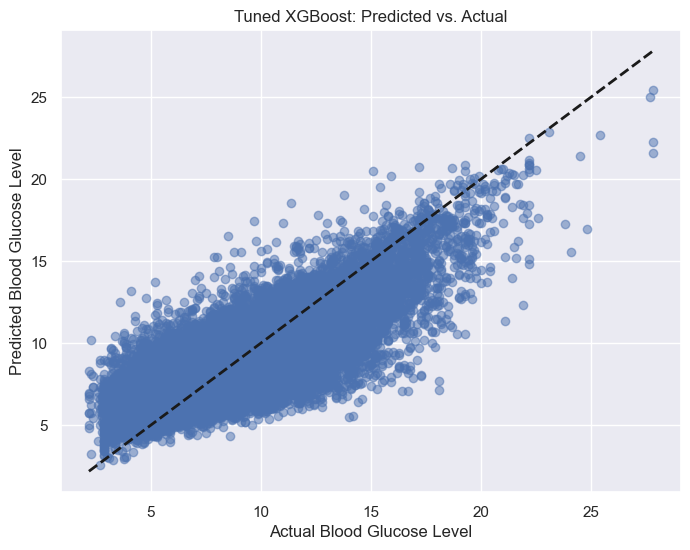

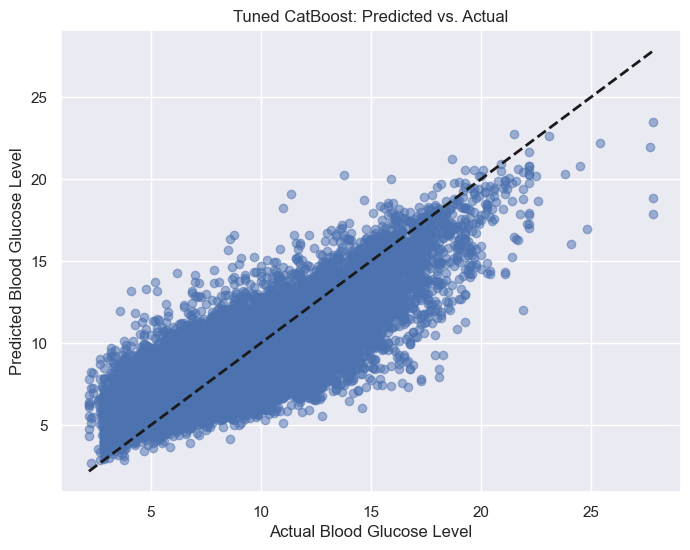

In [27]:
# Function to plot predicted vs actual
def plot_predicted_vs_actual(y_true, y_pred, model_name):
    plt.figure(figsize=(8,6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.xlabel('Actual Blood Glucose Level')
    plt.ylabel('Predicted Blood Glucose Level')
    plt.title(f'{model_name}: Predicted vs. Actual')
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--', lw=2)
    plt.show()

# Plot for Linear Regression
y_pred_lr = lr_model.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred_lr, 'Linear Regression')

# Plot for Tuned XGBoost
y_pred_xgb = best_xgb.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred_xgb, 'Tuned XGBoost')

# Plot for Tuned CatBoost
y_pred_cat = best_cat.predict(X_valid)
plot_predicted_vs_actual(y_valid, y_pred_cat, 'Tuned CatBoost')

#### Plotting Residuals
Residual plots help us see if there are patterns in the errors.

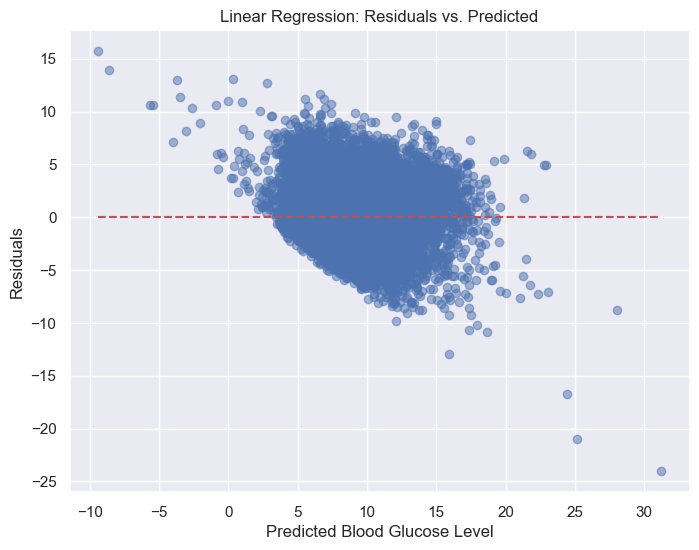

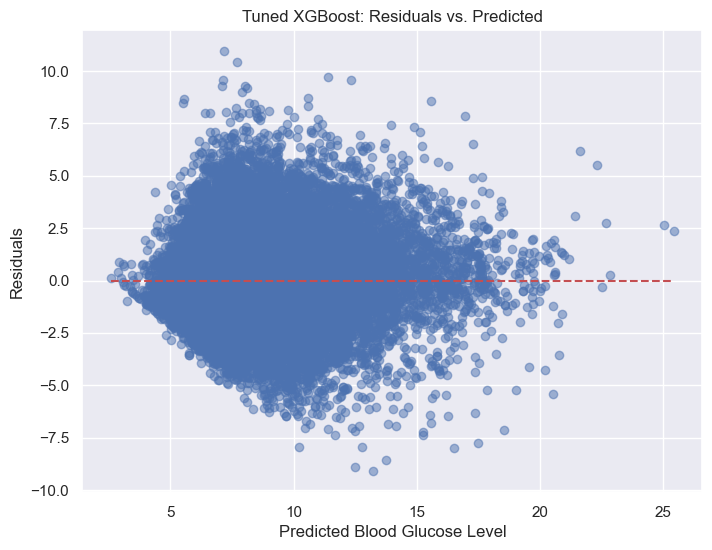

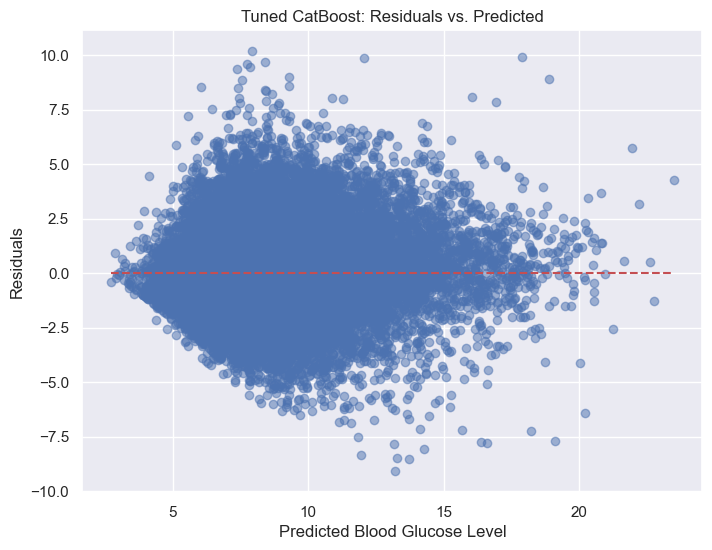

In [28]:
# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(8,6))
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.xlabel('Predicted Blood Glucose Level')
    plt.ylabel('Residuals')
    plt.title(f'{model_name}: Residuals vs. Predicted')
    plt.hlines(y=0, xmin=y_pred.min(), xmax=y_pred.max(), colors='r', linestyles='--')
    plt.show()

# Residuals for Linear Regression
plot_residuals(y_valid, y_pred_lr, 'Linear Regression')

# Residuals for Tuned XGBoost
plot_residuals(y_valid, y_pred_xgb, 'Tuned XGBoost')

# Residuals for Tuned CatBoost
plot_residuals(y_valid, y_pred_cat, 'Tuned CatBoost')

## Feature Importance Analysis using SHAP
SHAP (SHapley Additive exPlanations) values help us understand the impact of each feature on the model's predictions.

#### Installing SHAP

In [29]:
# Install SHAP if necessary
%pip install shap

#### Importing SHAP

In [30]:
import shap

#### Analyzing Feature Importance for Tuned CatBoost

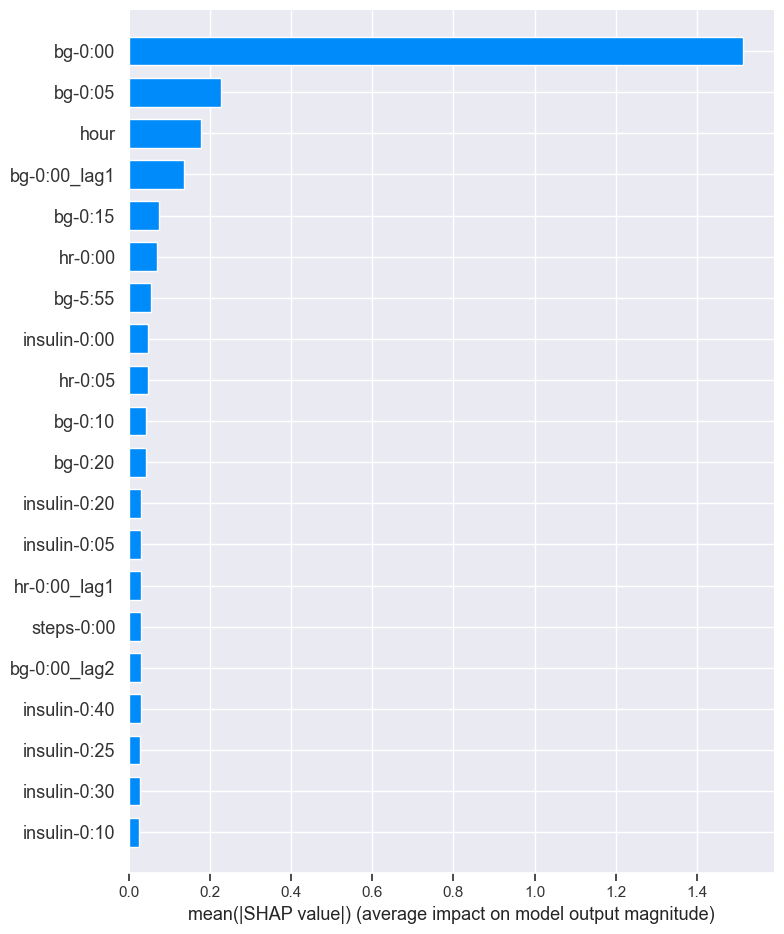

In [31]:
# Initialize the JS visualization code
shap.initjs()

# Explain the model's predictions using SHAP
explainer = shap.TreeExplainer(best_cat)
shap_values = explainer.shap_values(X_valid)

# Plot summary plot
shap.summary_plot(shap_values, X_valid, plot_type="bar")

This bar plot shows the average impact magnitude of each feature on the model output.

#### Detailed Feature Impact
To see how individual features affect predictions:

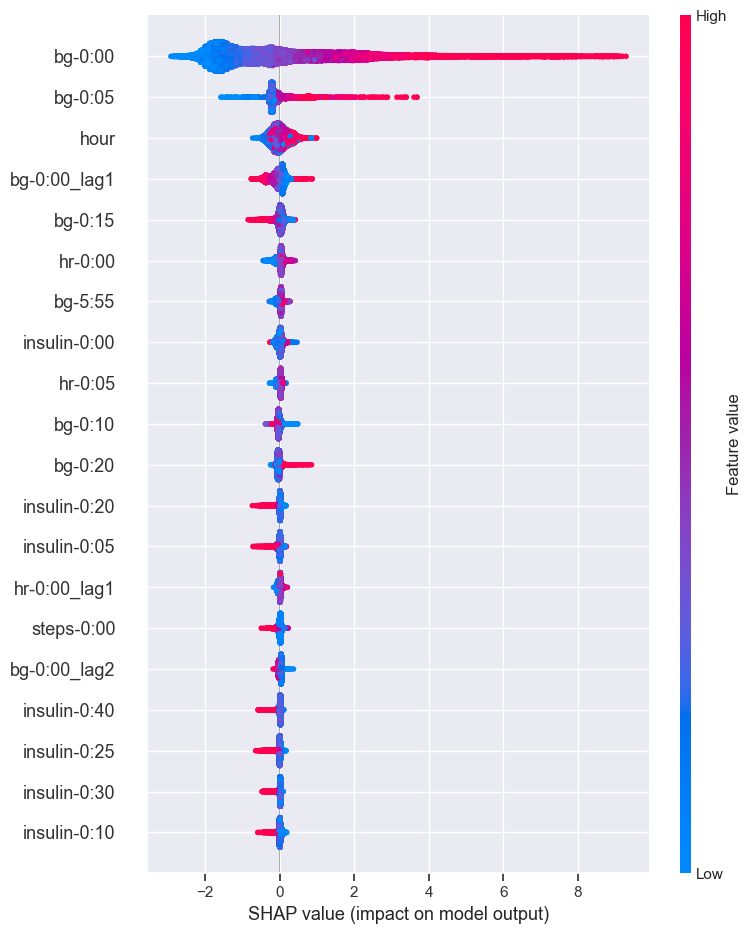

In [32]:
# Summary plot with detailed impact
shap.summary_plot(shap_values, X_valid)

#### Feature Importance for Tuned XGBoost
Similarly, for the XGBoost model:

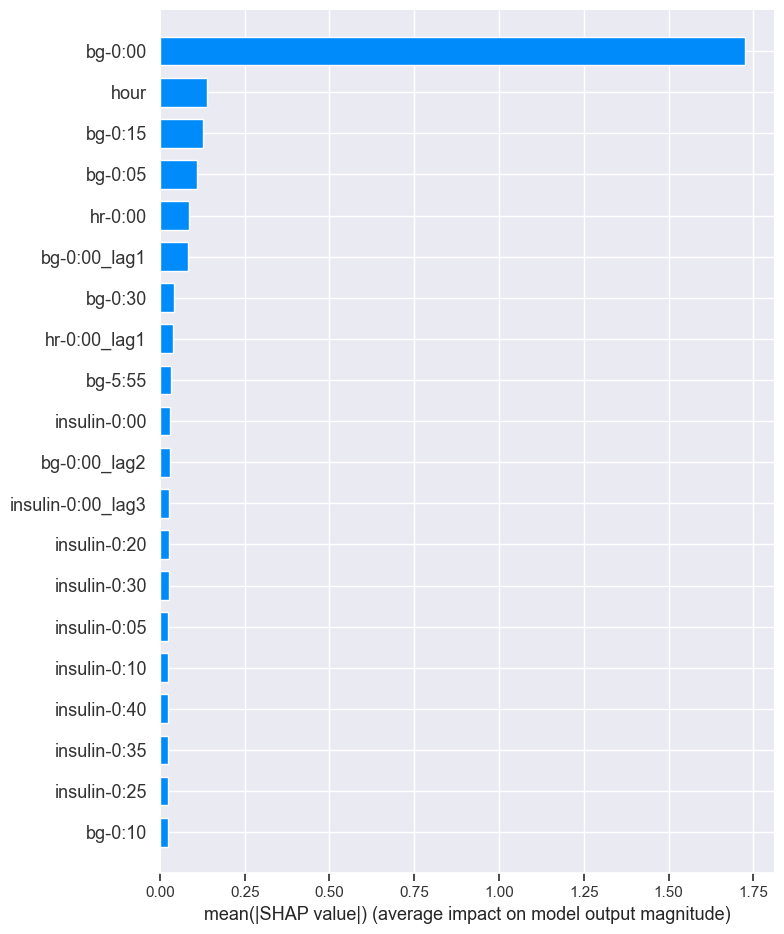

In [33]:
# For XGBoost
explainer_xgb = shap.TreeExplainer(best_xgb)
shap_values_xgb = explainer_xgb.shap_values(X_valid)

# Plot summary plot
shap.summary_plot(shap_values_xgb, X_valid, plot_type="bar")

## Cross-Validation
Using cross-validation helps us assess the model's performance more robustly.

#### Cross-Validation for Tuned CatBoost

In [34]:
from sklearn.model_selection import cross_val_score

# Since CatBoost handles cross-validation internally, we can use cv function
from catboost import cv, Pool

# Prepare the data pool
train_pool = Pool(X, y)

# Set up the parameters
params = best_cat.get_params()

# Perform cross-validation
cv_data = cv(
    params=params,
    pool=train_pool,
    fold_count=5,
    shuffle=True,
    partition_random_seed=42,
    verbose=False,
    early_stopping_rounds=50
)

# Get the best RMSE
best_rmse = cv_data['test-RMSE-mean'].min()
print(f'Cross-Validated RMSE: {best_rmse:.4f}')

Training on fold [0/5]

bestTest = 1.655665823
bestIteration = 1499

Training on fold [1/5]

bestTest = 1.633418977
bestIteration = 1499

Training on fold [2/5]

bestTest = 1.650832639
bestIteration = 1499

Training on fold [3/5]

bestTest = 1.648519735
bestIteration = 1499

Training on fold [4/5]

bestTest = 1.650500593
bestIteration = 1499

Cross-Validated RMSE: 1.6478


#### Cross-Validation for Tuned XGBoost

In [35]:
from sklearn.model_selection import KFold

# Prepare KFold
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Cross-validation scores
cv_scores = cross_val_score(
    best_xgb,
    X,
    y,
    cv=kf,
    scoring='neg_mean_squared_error',
    n_jobs=-1
)

# Convert to RMSE
rmse_scores = np.sqrt(-cv_scores)
print(f'Cross-Validated RMSE: {rmse_scores.mean():.4f} ± {rmse_scores.std():.4f}')

Cross-Validated RMSE: 1.7570 ± 0.0132


## Ensemble Models (XGBoost and CatBoost)
Ensembling combines the strengths of multiple models to potentially improve performance.

#### Averaging Predictions

In [36]:
# Predict on validation set using both models
y_pred_xgb = best_xgb.predict(X_valid)
y_pred_cat = best_cat.predict(X_valid)

# Average the predictions
y_pred_ensemble = (y_pred_xgb + y_pred_cat) / 2

# Evaluate the ensemble
rmse_ensemble = np.sqrt(mean_squared_error(y_valid, y_pred_ensemble))
print(f'Ensemble Model RMSE: {rmse_ensemble:.4f}')

Ensemble Model RMSE: 1.7001


#### Weighted Averaging
We can also assign weights based on individual model performances.

In [37]:
# Assign weights (you may adjust these based on model performance)
weight_xgb = 0.4
weight_cat = 0.6

# Weighted average
y_pred_weighted = (weight_xgb * y_pred_xgb) + (weight_cat * y_pred_cat)

# Evaluate the weighted ensemble
rmse_weighted = np.sqrt(mean_squared_error(y_valid, y_pred_weighted))
print(f'Weighted Ensemble Model RMSE: {rmse_weighted:.4f}')

Weighted Ensemble Model RMSE: 1.6903


#### Stacking Ensemble
Alternatively, we can use stacking to combine models.

In [40]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import RidgeCV

# Define base models
estimators = [
    ('xgb', best_xgb),
    ('cat', best_cat)
]

# Define the stacking regressor
stack_model = StackingRegressor(
    estimators=estimators,
    final_estimator=RidgeCV(),
    cv=3,
    n_jobs=-1
)

# Fit the stacking model
stack_model.fit(X_train, y_train)

# Predict on validation set
y_pred_stack = stack_model.predict(X_valid)

# Evaluate the stacking ensemble
rmse_stack = np.sqrt(mean_squared_error(y_valid, y_pred_stack))
print(f'Stacking Ensemble RMSE: {rmse_stack:.4f}')

Stacking Ensemble RMSE: 1.6622


#### All Model Evaluation
Compare all models including the ensemble models.

In [41]:
# Collect RMSE values
model_performance = {
    'Linear Regression': np.sqrt(mean_squared_error(y_valid, y_pred_lr)),
    'Tuned XGBoost': np.sqrt(mean_squared_error(y_valid, y_pred_xgb)),
    'Tuned CatBoost': np.sqrt(mean_squared_error(y_valid, y_pred_cat)),
    'Average Ensemble': rmse_ensemble,
    'Weighted Ensemble': rmse_weighted,
    'Stacking Ensemble': rmse_stack
}

# Print the RMSE values
for model_name, rmse_value in model_performance.items():
    print(f'{model_name} RMSE: {rmse_value:.4f}')

Linear Regression RMSE: 2.1332
Tuned XGBoost RMSE: 1.7712
Tuned CatBoost RMSE: 1.6671
Average Ensemble RMSE: 1.7001
Weighted Ensemble RMSE: 1.6903
Stacking Ensemble RMSE: 1.6622


#### Visualizing Model Performance Comparison
Bar Plot of RMSE Values

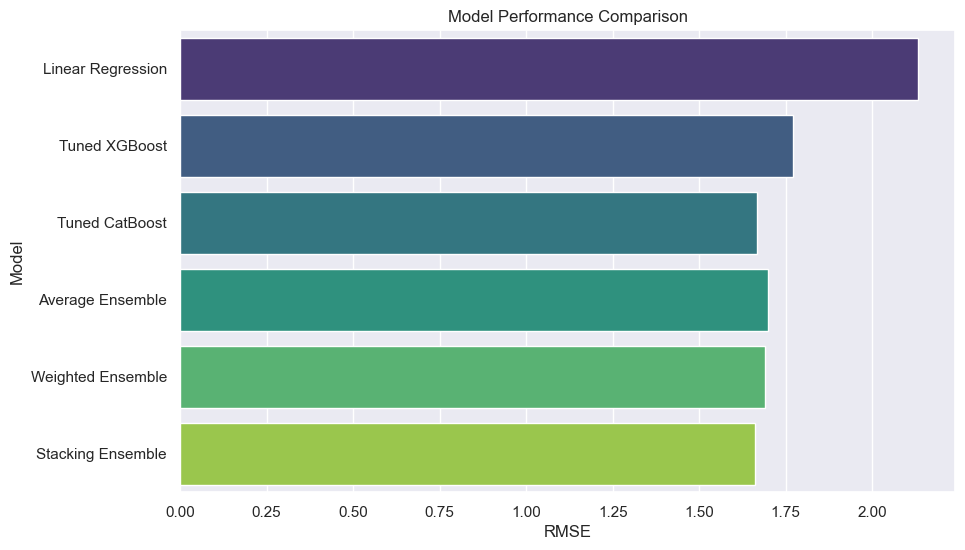

In [43]:
# Plot RMSE comparison
plt.figure(figsize=(10, 6))
model_names = list(model_performance.keys())
rmse_values = list(model_performance.values())

sns.barplot(x=rmse_values, y=model_names, palette='viridis', hue=model_names, dodge=False, legend=False)
plt.xlabel('RMSE')
plt.ylabel('Model')
plt.title('Model Performance Comparison')
plt.show()

## Preparing Submission
Once you've selected the best model, you can proceed to prepare the submission.

#### Using the Best Model to Predict on Test Data
In our study, the stacking ensemble performed the best:

In [44]:
# Ensure test data is processed the same way as training data
# (This should have been done previously)

# Predict on test data
test_preds = stack_model.predict(test_data)

# Round predictions to 2 decimal places
test_preds = test_preds.round(2)

# Prepare submission dataframe
submission = pd.DataFrame({
    'id': test['id'],
    'bg+1:00': test_preds
})

# Ensure the order matches the sample submission
submission = submission[['id', 'bg+1:00']]

# Save to CSV
submission.to_csv('submission.csv', index=False)